# 读取一个图片

In [1]:
import matplotlib.pyplot as plt

In [2]:
pwd

'D:\\360downloads\\毕业论文\\pytorch'

In [3]:
ls

 驱动器 D 中的卷是 新加卷
 卷的序列号是 5E20-BE4E

 D:\360downloads\毕业论文\pytorch 的目录

2020/03/23  17:34    <DIR>          .
2020/03/23  17:34    <DIR>          ..
2020/03/23  17:33    <DIR>          .ipynb_checkpoints
2020/03/23  17:29    <DIR>          database
2020/03/23  17:34               950 一步一步.ipynb
               1 个文件            950 字节
               4 个目录 212,221,317,120 可用字节


(2560, 2560, 3)
uint8
<class 'numpy.ndarray'>


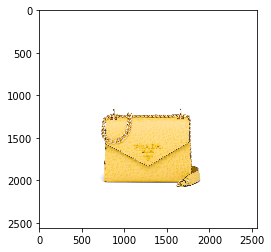

In [6]:
path = './database/430260.jpg'
img = plt.imread(path)
#图片的高H为460，宽W为346，颜色通道C为3
print(img.shape)
print(img.dtype)
print(type(img))
plt.imshow(img)
plt.show()

# 特征提取

## resnet 搭建

In [9]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F

In [42]:
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# 使用gpu

In [11]:
device 

device(type='cuda')

### 残差块

In [19]:
%%html
<img src="img/QQ截图20200323180206.png" width="80%">
卷积操作，输出计算公式

In [18]:
class Residual(nn.Module):  # 本类已保存在d2lzh_pytorch包中方便以后使用
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride) # 这里的padding指两（四）侧相当于公式里 p=2
        # out = n - 3 + 2 + 1 = n
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1) # stride = 1
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride) # padding = 0  将x改成和y_相等的形状
        else: 
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)

In [22]:
# use_1x1conv=False  输入和输出形状一致
blk = Residual(3, 3)
blk

Residual(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [23]:
X = torch.rand((4, 3, 6, 6))
blk(X).shape # torch.Size([4, 3, 6, 6])

torch.Size([4, 3, 6, 6])

In [28]:
# 增加输出通道数的同时减半输出的高和宽。
# use_1x1conv=True, stride=2
blk = Residual(3, 6, use_1x1conv=True, stride=2)
blk

Residual(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(3, 6, kernel_size=(1, 1), stride=(2, 2))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [35]:
temp = blk.conv1(X) # torch.Size([4, 3, 6, 6]) => torch.Size([4, 6, 3, 3])
temp = blk.conv2(temp) # torch.Size([4, 6, 3, 3]) => torch.Size([4, 6, 3, 3])
temp_x = blk.conv3(X) # torch.Size([4, 3, 6, 6]) => torch.Size([4, 6, 3, 3]) 方便与前计算

torch.Size([4, 6, 3, 3])

In [26]:
# （6, 3, 3）=> (6, 3, 3) => ()
blk(X).shape # torch.Size([4, 6, 3, 3])

torch.Size([4, 6, 3, 3])

## ResNet34 model

### 前两层

In [39]:
net = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

## 后面接了4个由残差块组成的模块

In [40]:
def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    if first_block:
        assert in_channels == out_channels # 第一个模块的通道数同输入通道数一致
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(in_channels, out_channels, use_1x1conv=True, stride=2))
        else:
            blk.append(Residual(out_channels, out_channels))
    return nn.Sequential(*blk)
net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
net.add_module("resnet_block2", resnet_block(64, 128, 2))
net.add_module("resnet_block3", resnet_block(128, 256, 2))
net.add_module("resnet_block4", resnet_block(256, 512, 2))

## 最后，与GoogLeNet一样，加入全局平均池化层后接上全连接层输出。

In [43]:
# 这里待会提取卷积层数据
net.add_module("global_avg_pool", d2l.GlobalAvgPool2d()) # GlobalAvgPool2d的输出: (Batch, 512, 1, 1)
net.add_module("fc", nn.Sequential(d2l.FlattenLayer(), nn.Linear(512, 10))) 

### 此时建立的模块有 4*4+2 = 18 层

In [45]:
#这里每个模块里有4个卷积层（不计算1×11×1卷积层），加上最开始的卷积层和最后的全连接层，共计18层。这个模型通常也被称为ResNet-18
X = torch.rand((1, 1, 224, 224))
for name, layer in net.named_children():
    X = layer(X)
    print(name, ' output shape:\t', X.shape)

0  output shape:	 torch.Size([1, 64, 112, 112])
1  output shape:	 torch.Size([1, 64, 112, 112])
2  output shape:	 torch.Size([1, 64, 112, 112])
3  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block1  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block2  output shape:	 torch.Size([1, 128, 28, 28])
resnet_block3  output shape:	 torch.Size([1, 256, 14, 14])
resnet_block4  output shape:	 torch.Size([1, 512, 7, 7])
global_avg_pool  output shape:	 torch.Size([1, 512, 1, 1])
fc  output shape:	 torch.Size([1, 10])


# 获取数据并训练

In [46]:
# 因为我的数据并没有标注，那么就
#用ImageNet数据集）上预训练一个神经网络模型，即源模型
# 创建一个新的神经网络模型，即目标模型。它复制了源模型上除了输出层外的所有模型设计及其参数。我们假设这些模型参数包含了源数据集上学习到的知识，且这些知识同样适用于目标数据集。我们还假设源模型的输出层跟源数据集的标签紧密相关，因此在目标模型中不予采用。
# 为目标模型添加一个输出大小为目标数据集类别个数的输出层，并随机初始化该层的模型参数。
# 在目标数据集（如椅子数据集）上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的。